# Data Science Portfolio 1#
Repository containing portfolio of data science projects completed by me for self learning. Presented in the form of jupyter Notebooks.

## Electronic Product Price Elasticity Project -
This portfolio main purpose is to analyze price data in the sense of analyzing the impact of different pricing data through time in various e-commerce platforms and measure the impression demand for brands that are direct competitors among different electronic products.

i.e. Does impression demand of competitor X increases if competitor Y increase their prices in the same or similar electronic products within a timeframe? Does free shipping boost impressions in electronic products? if yes, which products tend to have better results?


Electronic Product Price Elasticity Project - 

Ileana Cabada

About the dataset
The dataset used can be found at Kaggle and was created by Datafiniti. It contains several electronic products organized by ID and variables related to them: store, regular price , discounted price, product description, etc.
https://www.kaggle.com/datafiniti/electronic-products-prices

 

# Part 1  Data Cleaning and Preprocessing 

In [1]:
bg_color = (0.98,0.98,0.98)

In [2]:
import pandas as pd
import numpy as np
import datetime
import math
import matplotlib.pyplot as plt
import seaborn as sns
import re

#import warnings; warnings.filterwarnings(action='once')
from IPython.display import display, HTML, Image

In [3]:
#Upload csv data
pricing_data = 'category_price.csv'
df_2 = pd.read_csv (pricing_data)
pd.options.display.width = 0

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
print("Dataframe Dimensions:",df_2.shape)
pd.set_option('display.max_columns', 500)

Dataframe Dimensions: (34389, 30)


# Part 1.2  -. Exploratory Data Analysis  

In [5]:
# gives some infomation on columns types and number of null values
tab_info = pd.DataFrame(df_2.dtypes).T.rename(index={0:'column type'})
tab_info = tab_info.append(pd.DataFrame(df_2.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info = tab_info.append(pd.DataFrame(df_2.isnull().sum()/df_2.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
print ('-' * 10 + " Display information about column types and number of null values " + '-' * 10 )
print 
display(tab_info)

---------- Display information about column types and number of null values ----------


,Date_imp,Date_imp_d,Cluster,Category_name,name,price,disc_price,merchant,condition,Disc_percentage,isSale,Imp_count,brand,p_description,currency,dateAdded,dateSeen,dateUpdated,imageURLs,manufacturer,shipping,sourceURLs,weight,Date_imp_d.1,Day_n,year,month,month_n,day,Week_Number
column type,object,object,int64,object,object,float64,float64,object,object,float64,object,int64,object,object,object,object,object,object,object,object,object,object,object,object,object,int64,int64,object,int64,int64
null values (nb),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33624,15751,18278,9685,69,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,97.7755,45.8024,53.1507,28.1631,0.200646,0,0,0,0,0,0,0


## Selecting Product Condition for Price Analysis
Below we can notice that the product condition that obtained the most impressions is **New** condition. 

**As a result, we would proceed with our data analysis with only product condition labelled as new **

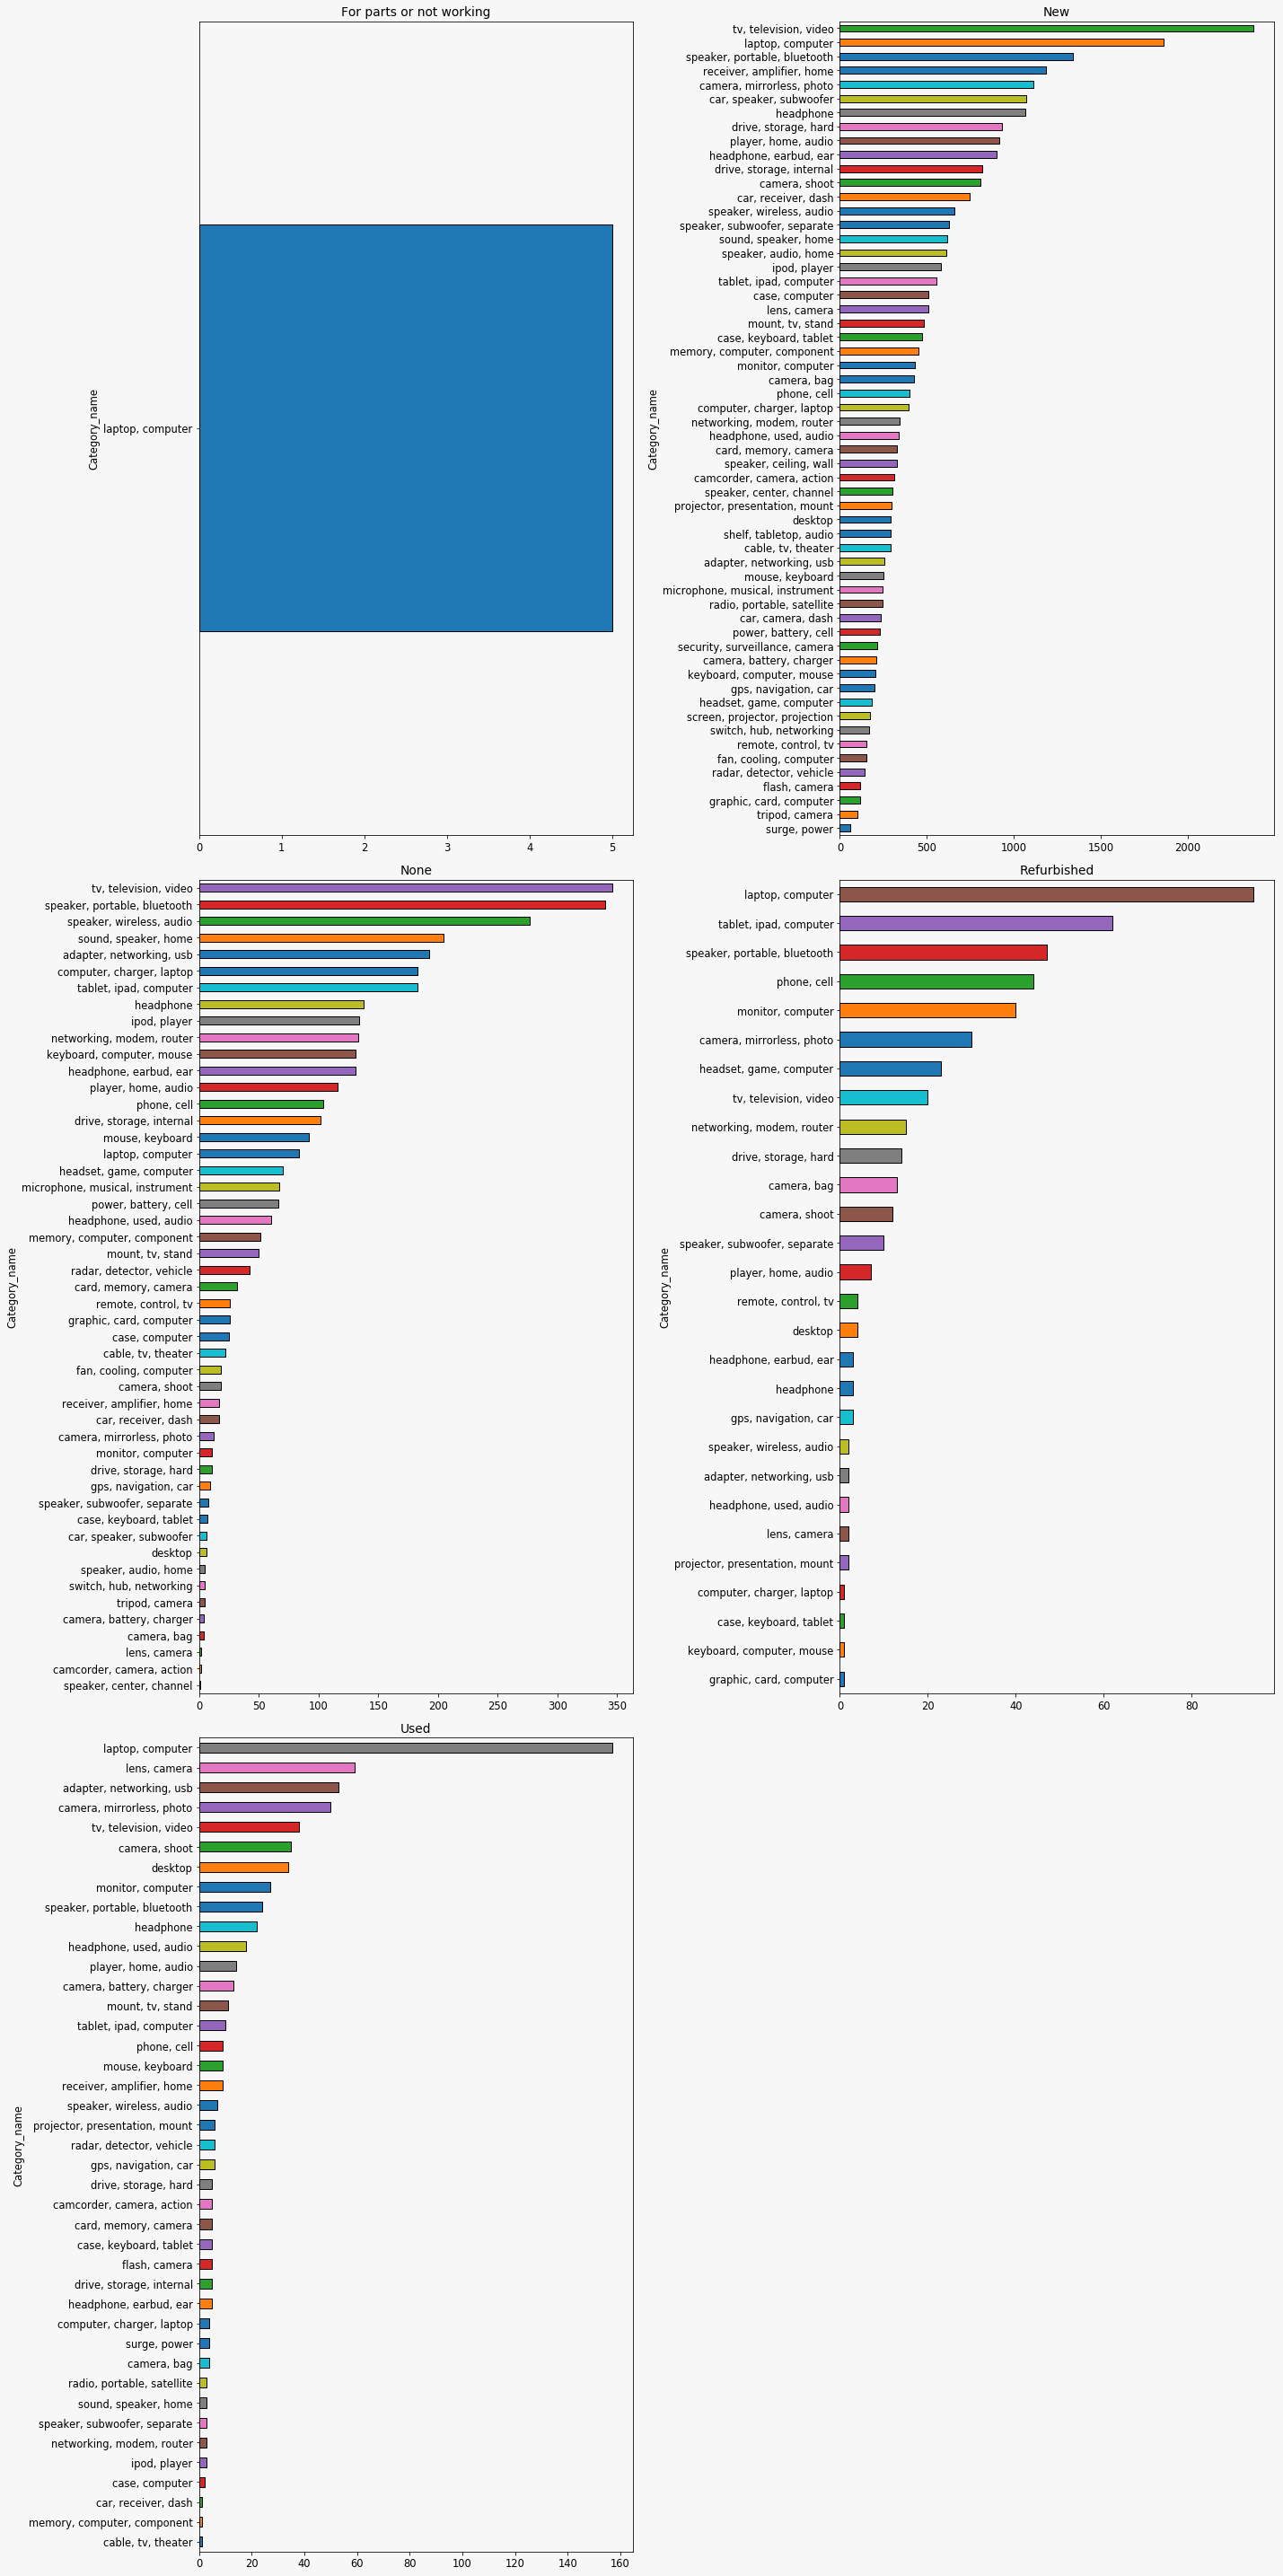

In [6]:
#Category impression count dataframe for subplots
Category_count = df_2.groupby(['Category_name','condition'])['Date_imp'].count().reset_index()


bg_color = (0.97,0.97,0.97)
plt.rcParams['figure.facecolor'] = bg_color
plt.rcParams['axes.facecolor'] = bg_color

#plt.figure(figsize=(20,40), facecolor='white')
plt.figure(figsize=(20,40))
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 11.5}
plt.rc('font', **font)

# plot numbering starts at 1, not 0
plot_number = 1
for condition_name, selection in Category_count.groupby('condition'):
    ax = plt.subplot(3,2, plot_number)
    selection.sort_values(by='Date_imp').plot.barh(x='Category_name', y='Date_imp', ax=ax, label=condition_name, legend=False, edgecolor='k')
    ax.set_title(condition_name)
    # Go to the next plot for the next loop
    plot_number = plot_number + 1
plt.tight_layout()

In [7]:
#Dataframe with only new products
df_new = df_2[df_2['condition'] =='New']

# Price Cross- Validation

Therefore, in order to proceed with pricing strategies in machine learning and do not have any currency exchange conflict in our results,this dataset filtered only USD dollar price advertisment.

Following,we can see that about 99% of our data from all products priced were flagged with USD currency:

## Select Only  USD Price Currency

In [8]:
#USD Price Currency
#Analyze type of currency for pricing 
x = df_new['currency'].value_counts()
print("Currency Percentage\n{}\n{}\nCurrency values count\n{}\n{}".format(
      50*"-", x / len(df_new.index) * 100, 50*"-", x))

Currency Percentage
--------------------------------------------------
USD    99.993253
EUR     0.003374
CAD     0.003374
Name: currency, dtype: float64
Currency values count
--------------------------------------------------
USD    29639
EUR        1
CAD        1
Name: currency, dtype: int64


In [9]:
print ('-' * 10 + " New dataframe with only USD Prices " + '-' * 10 )
df_us = df_new[df_new['currency'] == 'USD'] 
df_us['currency'].value_counts()

---------- New dataframe with only USD Prices ----------


USD    29639
Name: currency, dtype: int64

## Detecting Price Outliers by Product Name and  Merchant website

In order to identified any wrong typed information in price, we should analyze all prices per product name and  merchant website. Following, we would detect these wrong typed information by calculating each product name with previous conditions z score and dropped them from our dataset.

**Information about the Z-score**
The Z-score is the signed number of standard deviations by which the value of an observation or data point is above the mean value of what is being observed or measured.
The intuition behind Z-score is to describe any data point by finding their relationship with the Standard Deviation and Mean of the group of data points.

Z-score is finding the distribution of data where mean is 0 and standard deviation is 1 i.e. normal distribution.
In addition, this methodology is the same as standard scaler in machine learning for the standarization of your data.

**You must be wondering that, how does this help in identifying the outliers? **

Well, while calculating the Z-score we re-scale and center the data and look for data points which are too far from zero. These data points which are way too far from zero will be treated as the outliers.

In most of the cases a threshold of 3 or -3 is used i.e if the Z-score value is greater than or less than 3 or -3 respectively, that data point will be identified as outliers.

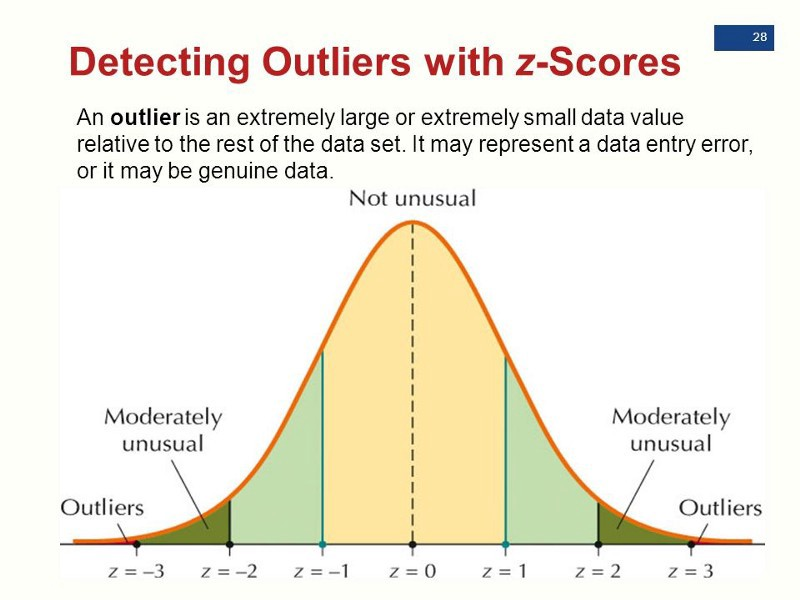

In [10]:
im4 = Image(filename= 'outlierimage.jpeg', width=350, height=350)
display(im4)

In [11]:
#Outlier detection functions

#Zscore function with conditional columns 
def zscore_columns(df, conditional_columns, price_column):
    price = df[price_column]
    Mean = df.groupby(conditional_columns).price.transform('mean')
    Standard = df.groupby(conditional_columns).price.transform('std')
    return ((price - Mean) / (Standard))

#Define the Z Score Outlier Threshold by 3 and -3
def anomaly_detect(df, zscore_column):
    zscore = df[zscore_column]
    result = np.where((zscore >= 3), True,
             np.where((zscore <= -3),True,False))
    return result

In [12]:
#Get unique price dataframe by product name, merchant, product condition 
unique_df = df_us[['name','merchant','price']]
unique_df = unique_df.drop_duplicates()


print("Dataframe with unique product name, merchant and price dimensions:", unique_df.shape)
print ('-' * 10 + " Unique_df Dataframe sample " + '-' * 10 )
unique_df[:5]

Dataframe with unique product name, merchant and price dimensions: (8450, 3)
---------- Unique_df Dataframe sample ----------


,name,merchant,price
0,Sanus VLF410B1 10-Inch Super Slim Full-Motion ...,Bestbuy.com,104.99
4,Boytone - 2500W 2.1-Ch. Home Theater System - ...,Walmart.com,69.00
6,Boytone - 2500W 2.1-Ch. Home Theater System - ...,Bestbuy.com,69.99
7,Boytone - 2500W 2.1-Ch. Home Theater System - ...,Bestbuy.com,66.99
8,Boytone - 2500W 2.1-Ch. Home Theater System - ...,Walmart.com,66.00


In [13]:
#Calculate Product Price Z Score by merchant and condition (unique_df)
unique_df['Zscore_1'] = zscore_columns(unique_df,['name','merchant'] ,'price')
print ('-' * 10 + " Unique_df Dataframe with Price Z score by Name and Merchant  " + '-' * 10 )

unique_df[:5]

---------- Unique_df Dataframe with Price Z score by Name and Merchant  ----------


,name,merchant,price,Zscore_1
0,Sanus VLF410B1 10-Inch Super Slim Full-Motion ...,Bestbuy.com,104.99,NaN
4,Boytone - 2500W 2.1-Ch. Home Theater System - ...,Walmart.com,69.00,0.001525
6,Boytone - 2500W 2.1-Ch. Home Theater System - ...,Bestbuy.com,69.99,1.388730
7,Boytone - 2500W 2.1-Ch. Home Theater System - ...,Bestbuy.com,66.99,0.000000
8,Boytone - 2500W 2.1-Ch. Home Theater System - ...,Walmart.com,66.00,-0.760844


In [14]:
# Identified Price Data Anomalies for each product grouped by Merchant(Vendor) and Condition of the product with Zscore
# by giving the threshold of larger than 3 or lower than -3
unique_df['Outlier_mrt_cond'] = anomaly_detect(unique_df, 'Zscore_1')

#Outlier Percentage
outlier_percentage = (len(unique_df[unique_df['Outlier_mrt_cond'] == True])/len(unique_df))
display("Outlier Percentage:"+"{:.2%}".format(outlier_percentage))

#Print example
print('-' * 10 + " Unique_df Dataframe with Price Z score by Merchant and Product Condition " + '-' * 10 )
unique_df[unique_df['Outlier_mrt_cond'] == True]


'Outlier Percentage:0.14%'

---------- Unique_df Dataframe with Price Z score by Merchant and Product Condition ----------


,name,merchant,price,Zscore_1,Outlier_mrt_cond
4361,Details About Alienware 13 R3 Aw13r3/13.3 Fhd/...,Bestbuy.com,1.00,-3.086848,True
5887,Details About Alienware 15 R3 Aw15r3/15.6 Fhd/...,Bestbuy.com,1.00,-3.111555,True
8426,"15.4 MacBook Pro with Touch Bar (Late 2016, Sp...",Bestbuy.com,2.00,-3.981794,True
13893,Apple MacBook - 12 - Core m5 - 8 GB RAM - 512 ...,Bestbuy.com,1.00,-3.198528,True
14662,LG Electronics OLED65C7P 65-Inch 4K Ultra HD S...,ebay.com,3799.99,3.468211,True
15063,Apple MacBook Pro with Touch Bar - 13.3 - Core...,Bestbuy.com,1.00,-3.848929,True
19133,GoPro HERO6 Black Camera,bhphotovideo.com,1199.00,3.004671,True
19507,Wireless HD Digital Kit,Walmart.com,506.61,3.840516,True
21048,"15.4 MacBook Pro with Touch Bar (Late 2016, Si...",Bestbuy.com,2.00,-3.062857,True
24572,D750 DSLR Camera Body with Adobe Creative Clou...,ebay.com,2269.83,3.710774,True


Previously we can analyzed that we count with **0.14% of price anomalies** by merchant and product condition. Therefore, we proceed and drop these outliers for further analysis

In [15]:
#Merged outlier detection according to zscore and price zscore per each product impression
df_us = pd.merge(df_us, unique_df,on = ['name','merchant','price'], how='inner')

#Outlier Percentage
print("Impression Outlier Count Identified: ", len(df_us[df_us['Outlier_mrt_cond'] == True]),"out of ", len(df_us))

#Clean outliers from dataframe sample
df_c = df_us[df_us['Outlier_mrt_cond'] == False]
print("Clean Dataframe Dimmensions: ", df_c.shape)

Impression Outlier Count Identified:  45 out of  29639
Clean Dataframe Dimmensions:  (29594, 32)


## Drop Entire Product Prices without Price Variation (std = 0)

Due that our dependent variable is impression count and our future features for cross price elasticity analysis depend on the interrelation between impression and price variation. We excluded prices without variation in our sample data

For further analysis on price, we will used the main variables in `disc_price` due that this feature is the current price in a given impression date

Briefly, we count with 1300 products out of 3388 price sample per product condition and merchant that report a standard deviation of 0.
As a result these product name per merchant and product condition are dropped for further analysis

Price per product condition and merchant with a standard deviation of 0:  1031 out of  2876
---------- Dataframe that Contains Prices with 0 Standard Deviation ----------


,index,Variation
0,True,23151
1,False,6443


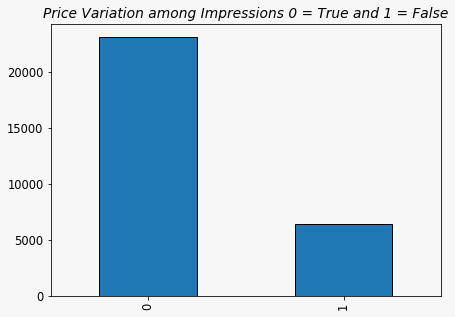

In [16]:
price_std = df_c.groupby(['merchant','name'])['disc_price'].std()
price_std = price_std.fillna(0).reset_index()
price_std = price_std.rename(columns={"disc_price": "price_std"})


threshold = .0
price_std['Variation'] = np.where((price_std['price_std'] > threshold), True,False)

#Print number of prices without variability std deviation 
print("Price per product condition and merchant with a standard deviation of 0: ",len(price_std[price_std['Variation'] ==False]),"out of ", len(price_std))

print ('-' * 10 + " Dataframe that Contains Prices with 0 Standard Deviation " + '-' * 10 )
price_std[price_std['Variation'] ==False][:5]

#Merged variation detection according to standard deviation
df_c = pd.merge(df_c , price_std, on =['merchant','name']) 

#Standard Deviation plot sample 
std_plot = df_c['Variation'].value_counts().reset_index()
display(std_plot)

plt.rcParams['figure.figsize'] = [7, 5]
std_plot.plot.bar( legend = False, width=.5, align= 'center', edgecolor ='k')
plt.title('Price Variation among Impressions 0 = True and 1 = False',color='Black', fontstyle='italic')
plt.show()


In [17]:
#Filter only the impressions with price variation for further analysis
df_clean = df_c[df_c['Variation'] ==True]

#Print Deleted Impressions with price variability
print("Sustainable Price Variability Impressions for further price regression analysis model: ", len(df_clean))
print("Percentage Deleted: "+"{:.2%}".format(1 - len(df_clean)/ len(df_c)))

Sustainable Price Variability Impressions for further price regression analysis model:  23151
Percentage Deleted: 21.77%


In [18]:
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

## Price Distribution Analysis

### Descriptive Analysis per Category

In [19]:
#Price Descriptive Analysis by Product Condition and Cluster Category
price_descriptive = df_clean.groupby(['Category_name'])['disc_price'].describe()

#Price Descritive Analysis by Product Condition and k_meanscluster (Category)
print ('-' * 10 + " Price Descriptive Analysis by Cluster and Product Condition " + '-' * 10 )
price_descriptive.head(15)

---------- Price Descriptive Analysis by Cluster and Product Condition ----------


,count,mean,std,min,25%,50%,75%,max
Category_name,,,,,,,,
"adapter, networking, usb",217.0,58.121521,71.029097,12.54,34.980,38.14,45.0700,379.00
"cable, tv, theater",78.0,132.089872,56.388091,32.99,79.990,162.47,173.4975,209.99
"camcorder, camera, action",225.0,338.649956,194.155161,6.99,282.500,399.00,399.9900,799.99
"camera, bag",247.0,70.115304,68.277425,14.99,29.990,49.99,76.9400,309.95
"camera, battery, charger",126.0,77.152619,128.687976,19.99,33.360,39.99,50.9900,639.00
"camera, mirrorless, photo",1072.0,1141.414711,1106.916135,2.00,498.000,797.99,1504.9800,5010.50
"camera, shoot",744.0,569.181062,272.225647,50.00,338.000,552.95,759.0000,1228.99
"car, camera, dash",203.0,99.978030,42.739028,16.99,61.990,99.99,133.9900,189.99
"car, receiver, dash",712.0,273.439059,404.961246,26.99,89.990,128.97,329.9900,2599.98


## Price Distribution Vizualization per Category

### Price Quantile Vizualization (Boxplot)

[Text(0.5,1,'Price Distribution per Category ')]

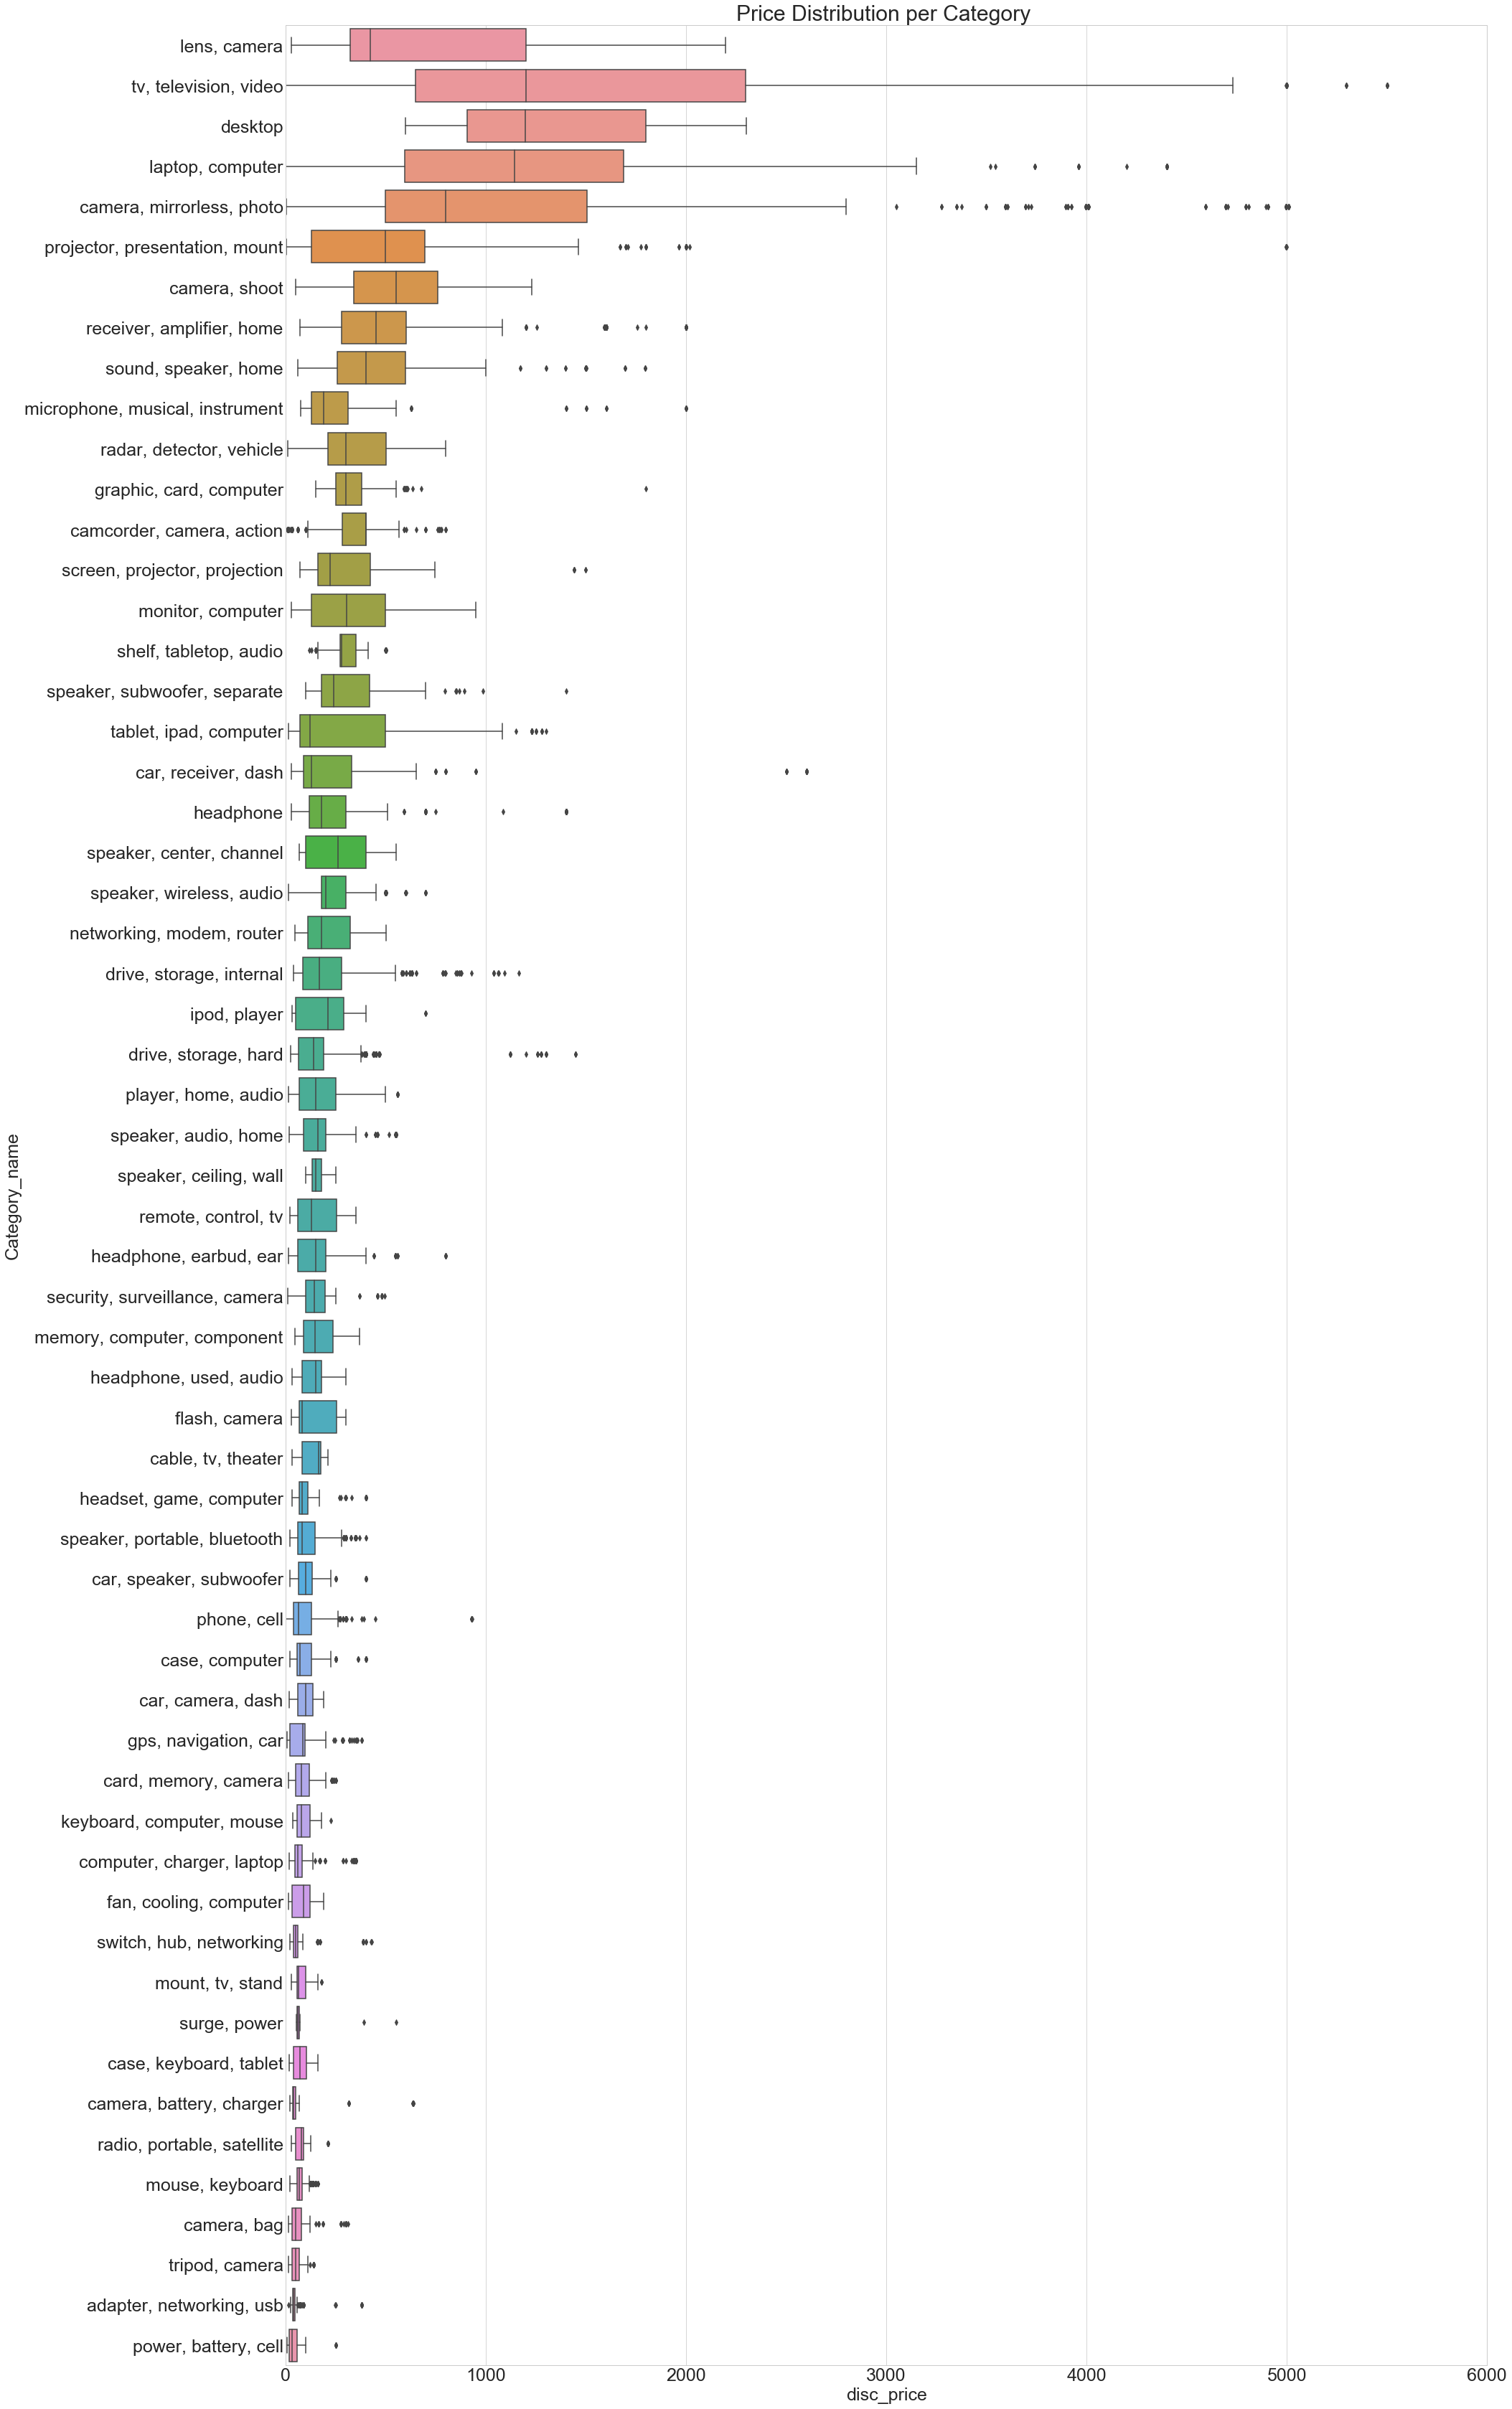

In [20]:
#Price Boxplot per Category
ranks = df_clean.groupby("Category_name")["disc_price"].mean().fillna(0).sort_values()[::-1].index

plt.rcParams['figure.figsize'] = [30, 60]
plt.rcParams['font.size'] = 25
sns.set_style("whitegrid")
ax1 = sns.boxplot( x = df_clean['disc_price'] , y = df_clean['Category_name'], orient = "h", order = ranks)
ax1.set(xlim = (0, 6000))
ax1.set(title = "Price Distribution per Category ")

### Price Frequency Distribution

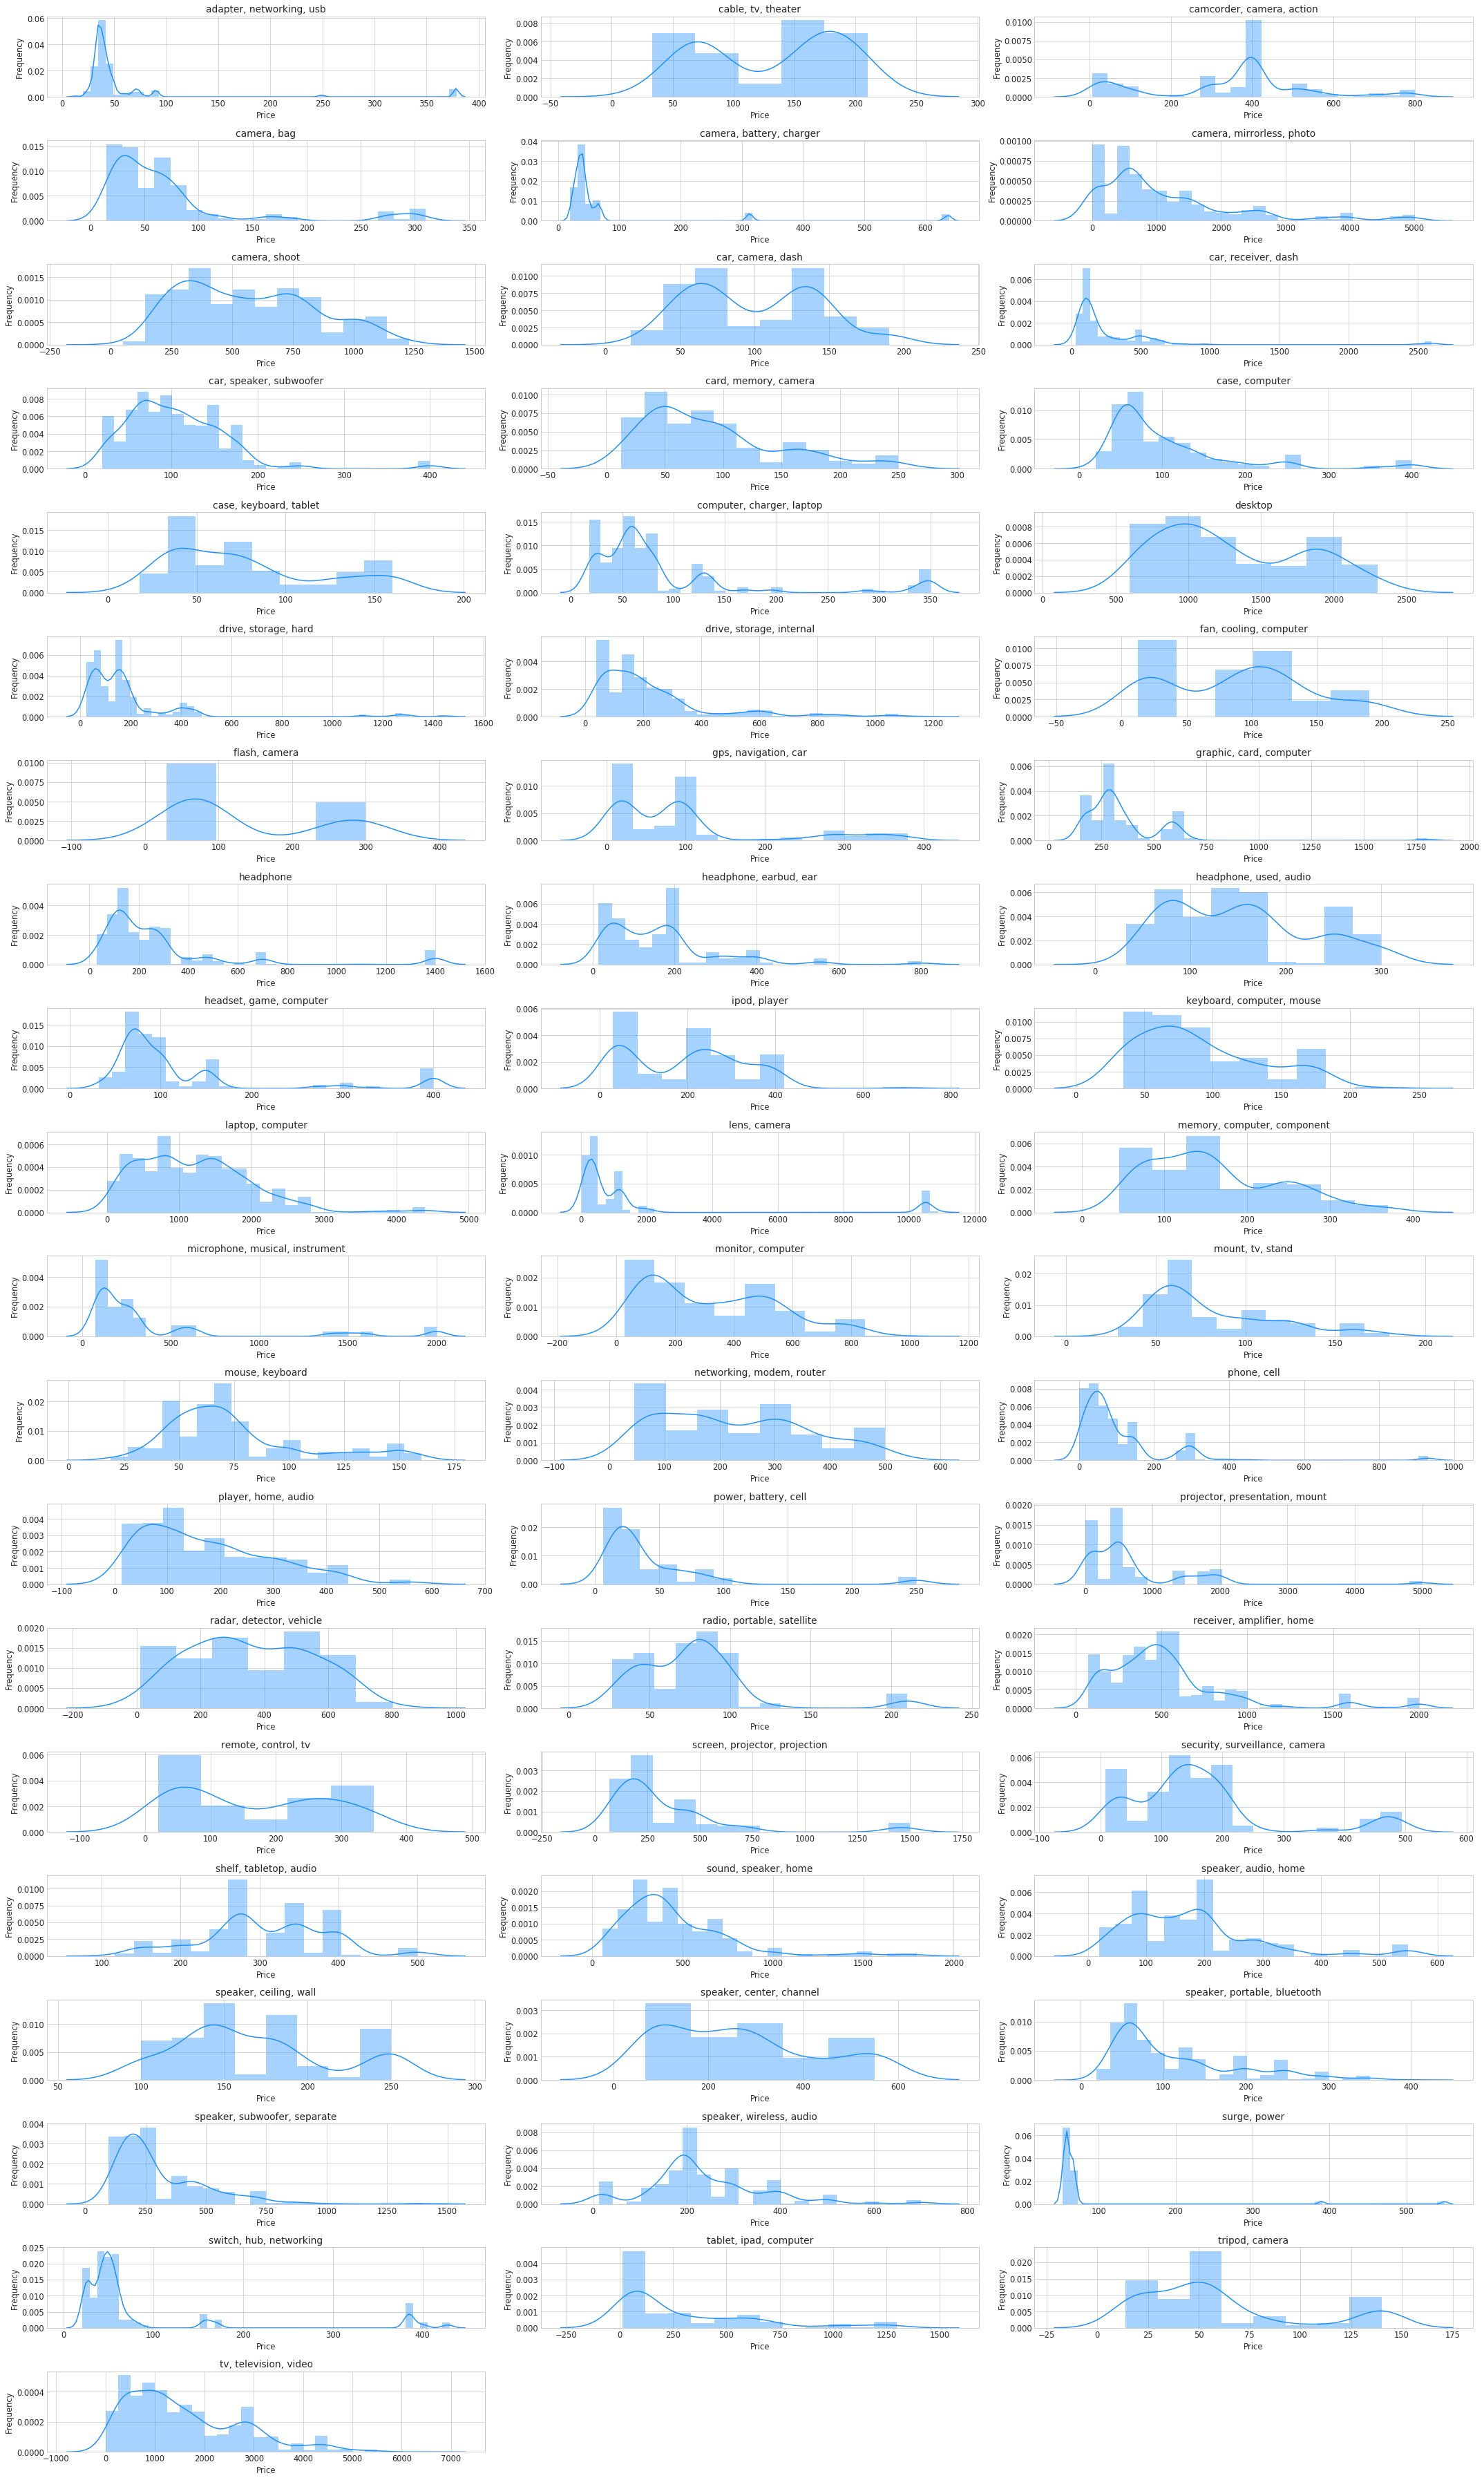

In [21]:
# Price Distribution Plot per Category
plt.figure(figsize=(30,50))
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 11.5}
plt.rc('font', **font)


# Price Distribution Plot per Category
plot_number = 1
for category_name, selection in df_clean.groupby('Category_name'):
    ax = plt.subplot(20,3, plot_number)
    sns.distplot( df_clean.loc[df_clean.Category_name == category_name, "disc_price"] , color="dodgerblue")
    ax.set(title = category_name, xlabel = 'Price',ylabel = 'Frequency')

    # Go to the next plot for the next loop
    plot_number = plot_number + 1
plt.tight_layout()

## Discount Price Correlation with Impression Count (> 30) per Category

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Text(0.5,1,'Discount Price Correlation with Impression Count (> 30) per Category')

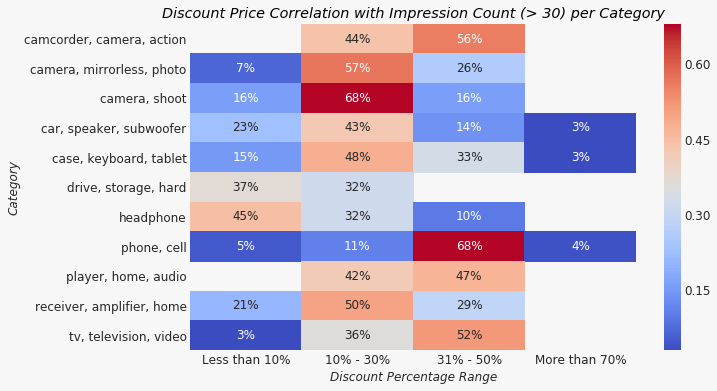

In [22]:
#Enclosed only Sale prices for Discount Range Heatmap
disc_df =  df_clean[df_clean['isSale'] =='Yes']

#Discount Bracket function
def percentage_clust(df, disc_column):
    disc = df[disc_column]
   
    result = np.where(( disc <= .099), 'Less than 10%',
             np.where(((disc >= .10) & (disc <= .30)), '10% - 30%',
             np.where(((disc >= .31) & (disc <= .50)), '31% - 50%',
             np.where(((disc >= .51) & (disc <= .70)), '51% - 70%',
             np.where((disc >= .71), 'More than 70%', 'Other')))))
    return result

#Labelled each Disc_percentage into a discount bracket
disc_df['Percentage_bracket'] = percentage_clust(disc_df, 'Disc_percentage')

#Create Dataframe for heatmap
heat_mapdisc = disc_df.groupby(['Category_name','Percentage_bracket'])['Disc_percentage'].count().reset_index()
heat_mapdisc = heat_mapdisc.rename(columns = {"Disc_percentage": "Count"})
heat_mapdisc['Total_Count'] = heat_mapdisc['Count'].groupby(heat_mapdisc['Category_name']).transform('sum')

#Percentage from Total Count
heat_mapdisc['Percentage_Totalcount'] = round((heat_mapdisc['Count'] / heat_mapdisc['Total_Count']),2)


#Heatmap with at least 30 Impression Count
heat_mapdisc = heat_mapdisc[heat_mapdisc['Total_Count'] > 30]
#Create pivot table for sns heatmap and re-order the columns
pivot_heatmapdisc = heat_mapdisc.pivot(index = 'Category_name', columns = 'Percentage_bracket', values = 'Percentage_Totalcount')

#Reorder columns
column_order = ['Less than 10%', '10% - 30%', '31% - 50%','More than 70%']
pivot_heatmapdisc = pivot_heatmapdisc.reindex(column_order, axis=1)

#Heatmap plot of the Impressions Distribution Count for Discount Range per Category
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12
bg_color = (0.97,0.97,0.97)
plt.rcParams['figure.facecolor'] = bg_color
plt.rcParams['axes.facecolor'] = bg_color
fmt = lambda x,pos: '{:.00%}'.format(x)
fig, ax = plt.subplots(1)
heatmap_pivot = sns.heatmap(pivot_heatmapdisc , cmap='coolwarm',robust=True,annot=True,annot_kws={'size':12},fmt='.00%')
plt.xlabel('Discount Percentage Range',fontstyle='italic')
plt.ylabel('Category',fontstyle='italic')
plt.title("Discount Price Correlation with Impression Count (> 30) per Category",color='Black', fontstyle='italic')

## Merchant Impression Percentage Share Distribution

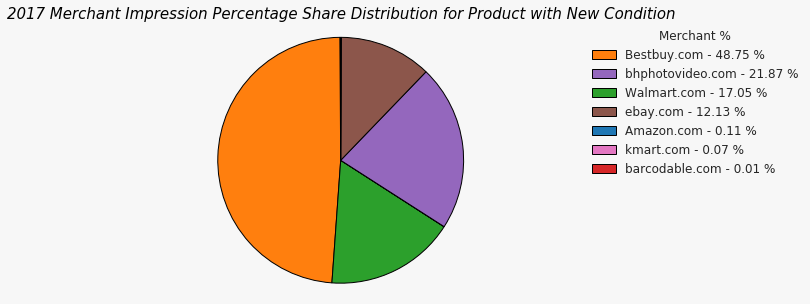

In [23]:

#Pie Chart Dataframe    
pie_web = df_clean.groupby('merchant').agg({'Date_imp':'count'}).reset_index()
pie_web = pie_web.rename(columns = {'merchant':'Merchant','Date_imp':'Impressions'})

x = pie_web['Merchant']
Imp_count = pie_web['Impressions']
percent_imp = 100.*Imp_count/Imp_count.sum()

#Pie Chart Plot
plt.rcParams['figure.figsize'] = [8, 5]
patches, texts = plt.pie(Imp_count  ,startangle = 90, shadow = False, wedgeprops = {"edgecolor":"k",'linewidth': 1, 'antialiased': True})
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, percent_imp)]
sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, Imp_count),
                                          key=lambda x: x[2],
                                          reverse=True))
plt.legend(patches, labels, title = 'Merchant %', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,
           fontsize = 12)
    
plt.title('2017 Merchant Impression Percentage Share Distribution for Product with New Condition',fontsize = 15,color='Black', fontstyle='italic' )
plt.axis('equal')
plt.show()

## 2017 Impression Time Analysis by Week and Month

Dataframe dimensions with impressions: (23151, 34)


,Products,Merchants,Impressions
2017 Quantity,908,7,23151


None


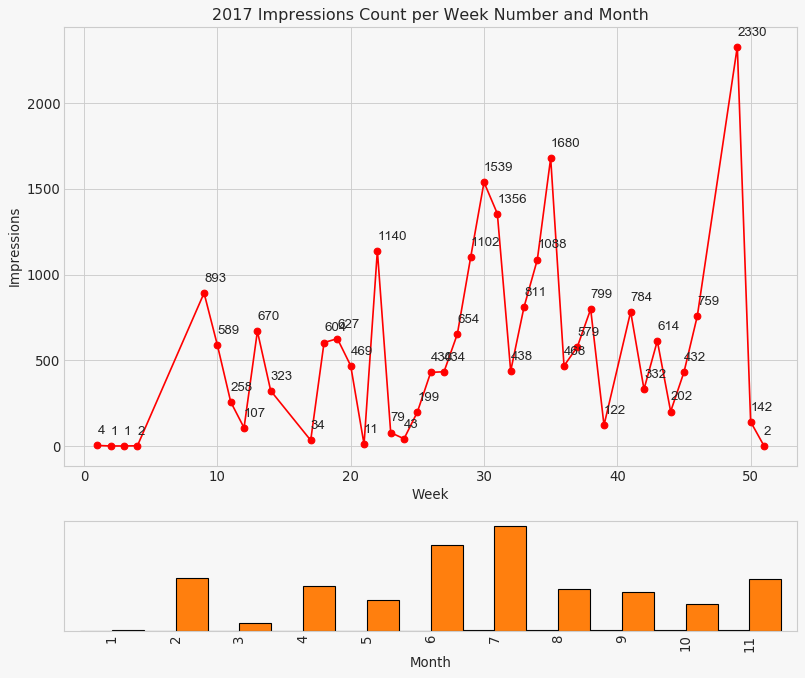

In [24]:
print("Dataframe dimensions with impressions:" ,df_clean.shape)

summary = pd.DataFrame([{'Merchants': len(df_clean['merchant'].unique()),    
               'Impressions': len(df_clean['year']),
               'Products': len(df_clean['name'].unique()),  
              }], columns = [ 'Products','Merchants','Impressions'], 
              index = ['2017 Quantity'])

print(display(summary))

# Create Fig and gridspec
fig = plt.figure(figsize=(16, 10), dpi= 80)
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

# Define the axes
ax_main = fig.add_subplot(grid[:-1, :-1])
ax_bottom = fig.add_subplot(grid[-1, 0:-1], xticklabels=[], yticklabels=[])

sns.set_style("whitegrid")

#Linearplot for impressions per week during 2017
l_plot = df_clean.groupby('Week_Number')['Date_imp'].count().reset_index()
bar_subplot = df_clean.groupby('month')['Date_imp'].count().reset_index()
month_ = bar_subplot['month']
week = l_plot['Week_Number']
count_imp = l_plot['Date_imp']
count_impmon = bar_subplot['Date_imp']

#
ax_main.plot(week ,count_imp,color='red', marker='o')
ax_main.set(title='2017 Impressions Count per Week Number and Month', xlabel='Week', ylabel='Impressions')
for x,y in zip(week,count_imp):

    label = "{:.0f}".format(y)

    ax_main.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='left') # horizontal alignment can be left, right or center


bar_subplot.plot.bar(ax=ax_bottom, legend = False, width=1, align= 'center',edgecolor='k')
ax_bottom.set(xlabel='Month')
ax_bottom.set_xticklabels(np.arange(min(month_), max(month_)+1))
ax_bottom.grid(False)
plt.show()

## 2017 Merchant Impression Time Analysis by  Month

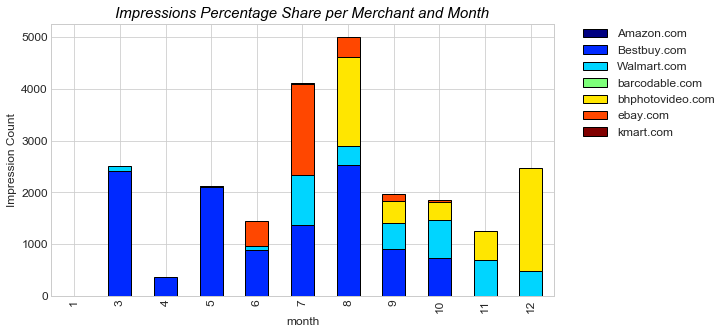

In [25]:
#Dataframe for stacked plot 
plt.rcParams['figure.figsize'] = [9, 5]
b_imp = df_clean.groupby(['month','merchant'])['name'].count()
b_imp = pd.DataFrame(b_imp)
b_imp = b_imp.reset_index()


#Data Preprocessing for Stacked plot by impressions count 
cmp = plt.cm.get_cmap('jet')
pivot_spaguetti = b_imp.pivot(index='month', columns='merchant', values='name')
pivot_spaguetti.plot.bar(stacked=True,cmap=cmp, edgecolor='k')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Impressions Percentage Share per Merchant and Month",fontsize = 15,color='Black', fontstyle='italic')
plt.ylabel("Impression Count")
plt.show()

## Merchant Percentage Share by Month

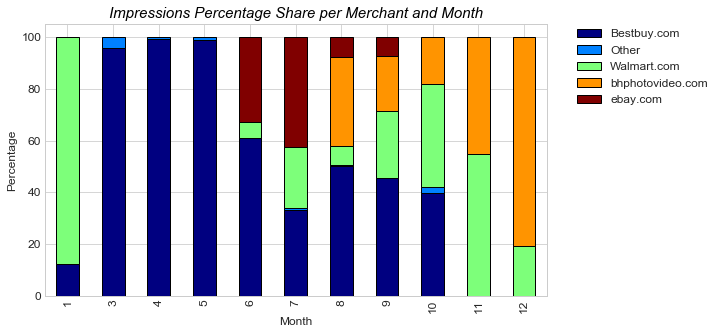

In [26]:
#Total Impressions per month
b_imp['Impressions_month'] = b_imp['name'].groupby(b_imp['month']).transform('sum')
#Impressions Percentage Share by year and vendor
b_imp['Percentage_share'] = round(((b_imp['name'])/(b_imp['Impressions_month']))*100,2)


#Data processing for Stacked plot (Classify as Other to the Merchant that has less than %5 impressions percentage share per year)
b_imp['Vendor_5p'] = np.where(b_imp.Percentage_share < 5, 'Other', b_imp['merchant'])
stck_plot_5 = b_imp.groupby(['month','Vendor_5p'])['Percentage_share'].sum()
stck_plot_5 = pd.DataFrame(stck_plot_5).reset_index()
stck_plot_5 = stck_plot_5.rename(columns={'month': 'Month', 'Vendor_5p': 'Merchant',})
pivot_df_5 =stck_plot_5

#Convert to pivot table 
pivot_df_5 = pivot_df_5.pivot(index='Month', columns='Merchant', values='Percentage_share')

#Stacked plotof number of impressions per month by website
fig=plt.figure(figsize=(40,32))
cmp = plt.cm.get_cmap('jet')
pivot_df_5.plot.bar(stacked=True, cmap=cmp,  edgecolor='k')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Impressions Percentage Share per Merchant and Month",fontsize = 15,color='Black', fontstyle='italic')
plt.ylabel("Percentage")
plt.show()

# Price Dataframe Correlogram 

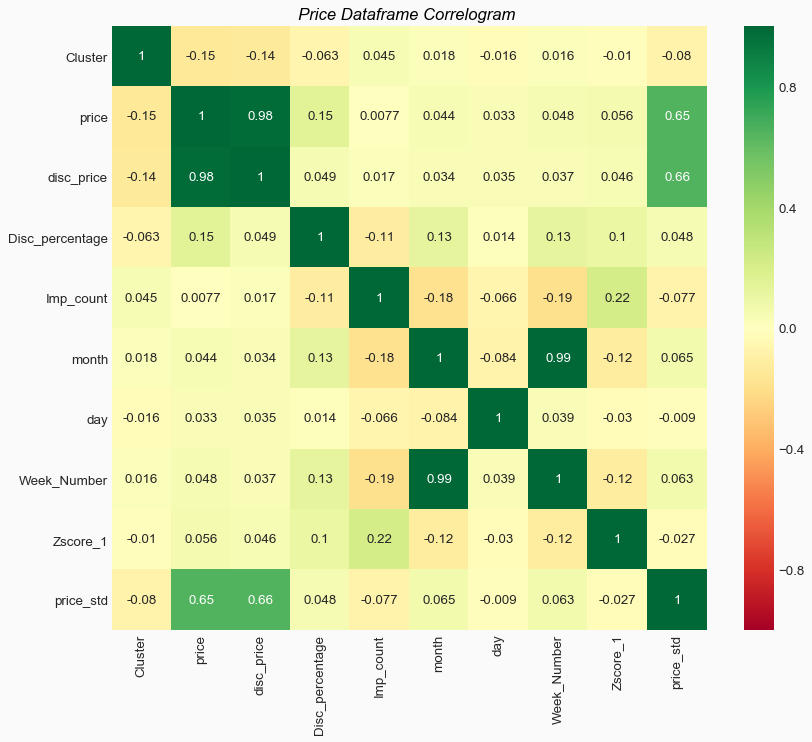

In [27]:
#Setting background color for all graphs
bg_color = (0.98,0.98,0.98)
plt.rcParams['figure.facecolor'] = bg_color
plt.rcParams['axes.facecolor'] = bg_color

#Drop Columns with same values
df_clean = df_clean.drop(columns=['year', 'Outlier_mrt_cond','Variation'])
#Correlogram Plot
plt.figure(figsize=(12,10), dpi= 80)
column_corr = sns.heatmap(df_clean.corr(), xticklabels=df_clean.corr().columns, yticklabels=df_clean.corr().columns, cmap ='RdYlGn',robust = True,annot = True, annot_kws = {'size':12}, vmin = -1)

# Adjustments
plt.title('Price Dataframe Correlogram ', fontsize = 15,color='Black', fontstyle='italic')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()